In [31]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

from PIL import Image, ImageDraw

import numpy as np
import base64
import httplib2
import os

# matplot
from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
# Google' variables and environments
DISCOVERY_URL='https://{api}.googleapis.com/$discovery/rest?version={apiVersion}'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '{}/demo/google_cloud_vision.json'.format(os.getcwd())

# variables
FACE_RESOLUTION = 100 # Face' size 100 by 100 pixels

In [35]:
def get_vision_service():
    credentials = GoogleCredentials.get_application_default()
    return discovery.build('vision', 'v1', credentials=credentials,
                           discoveryServiceUrl=DISCOVERY_URL)


def detect_face(face_file, max_results=10):
    """Uses the Vision API to detect faces in the given file.

    Args:
        face_file: A file-like object containing an image with faces.

    Returns:
        An array of dicts with information about the faces in the picture.
    """
    image_content = face_file.read()
    batch_request = [{
        'image': {
            'content': base64.b64encode(image_content).decode('UTF-8')
            },
        'features': [{
            'type': 'FACE_DETECTION',
            'maxResults': max_results,
            }]
        }]

    service = get_vision_service()
    request = service.images().annotate(body={
        'requests': batch_request,
        })
    response = request.execute()

    if not response['responses'][0]:
        raise ValueError('No faces were detected in {}.'.format(face_file))

    return response['responses'][0]['faceAnnotations'], len(response['responses'][0]['faceAnnotations'])


def highlight_faces(image, faces, output_filename=None):
    """Draws a polygon around the faces, then saves to output_filename.

    Args:
      image: a file containing the image with the faces.
      faces: a list of faces found in the file. This should be in the format
          returned by the Vision API.
      output_filename: the name of the image file to be created, where the faces
          have polygons drawn around them.
    """
    im = Image.open(image)
    draw = ImageDraw.Draw(im)

    for face in faces:
        box = [(v.get('x', 0.0), v.get('y', 0.0)) for v in face['fdBoundingPoly']['vertices']]
        draw.line(box + [box[0]], width=15, fill='#00ff00')

    del draw
    
    if output_filename:
        im.save(output_filename)

    return im
    

def extract_faces(image, faces):
    """Extract faces from image.

    Args:
      image: a file containing the image with the faces.
      faces: a list of faces found in the file. This should be in the format
          returned by the Vision API.
    Return array of faces
    """
    arr = np.zeros()
    I = Image.open(image)

    for face in faces:
        box = [(v.get('x', 0.0), v.get('y', 0.0)) for v in face['fdBoundingPoly']['vertices']]
        Arr.line(box + [box[0]], width=5, fill='#00ff00')
    
    return arr    

In [86]:
group = '{}/../test/g6.jpg'.format(os.getcwd())
single = '{}/../test/s6.jpg'.format(os.getcwd())

(-0.5, 3263.5, 2447.5, -0.5)

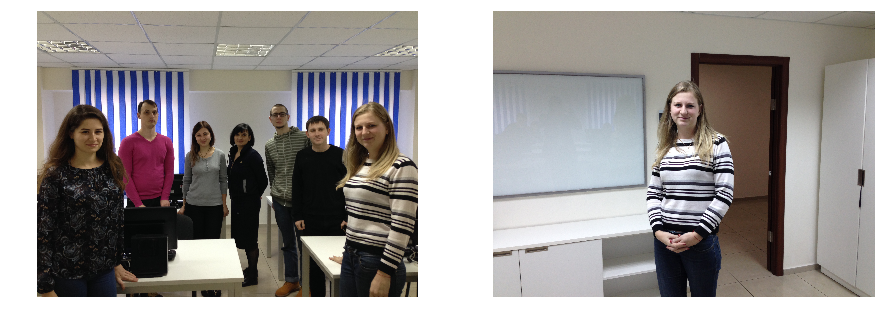

In [87]:
# plot group image
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(Image.open(group))    
plt.axis("off")

# plot single image
plt.subplot(122)
plt.imshow(Image.open(single))    
plt.axis("off")

In [88]:
result = dict(group=dict(image_file=group, original_image=None, labeled_image=None, faces=None, total_faces=None, faces_matrix=None),
              single=dict(image_file=single, original_image=None, labeled_image=None, faces=None, total_faces=None, faces_matrix=None))

for item in result:
    with open(result[item]['image_file'], 'rb') as image:
        result[item]['original_image'] = Image.open(result[item]['image_file'])
        result[item]['faces'], result[item]['total_faces'] = detect_face(image)
        
        print('{}: found {} face{}'.format(item, result[item]['total_faces'], '' if result[item]['total_faces'] == 1 else 's'))

        # Reset the file pointer, so we can read the file again
        image.seek(0)
        
        result[item]['labeled_image'] = highlight_faces(image, result[item]['faces'])

single: found 1 face
group: found 7 faces


(-0.5, 3263.5, 2447.5, -0.5)

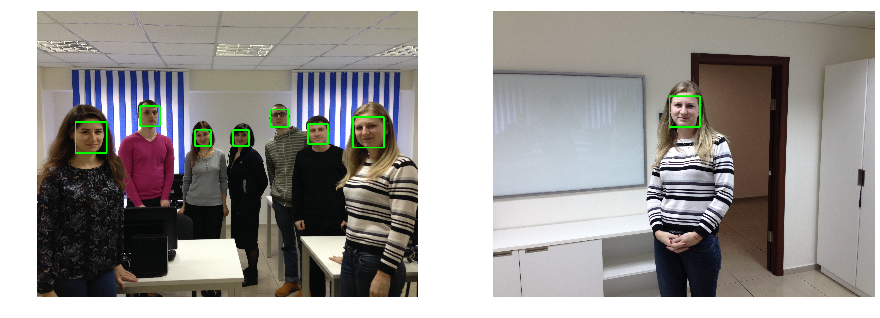

In [89]:
# plot group image
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(result['group']['labeled_image'])    
plt.axis("off")

# plot single image
plt.subplot(122)
plt.imshow(result['single']['labeled_image'])    
plt.axis("off")

Show detected faces
==

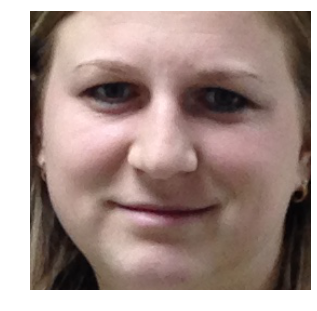

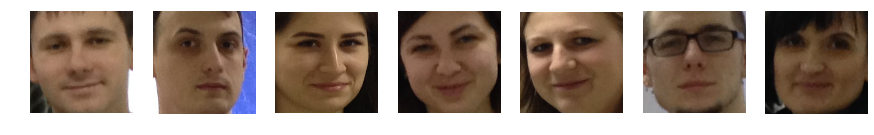

In [90]:
for item in result:
    
    fig = plt.figure(figsize=(15,5))

    for i, face in enumerate(result[item]['faces']):
        pos = i+1
        plt.subplot(1, result[item]['total_faces'], pos)
        vertices = face['fdBoundingPoly']['vertices']
        box = (vertices[0]['x'], vertices[1]['y'], vertices[1]['x'], vertices[2]['y'],)        
        plt.imshow(result[item]['original_image'].crop(box))    
        plt.axis("off")

Create matrix
==

box: (1507, 736, 1767, 995)
rotated box: (1457, 686, 1817, 1045)
box: (2321, 972, 2491, 1142)
rotated box: (2271, 922, 2541, 1192)
box: (884, 820, 1055, 992)
rotated box: (834, 770, 1105, 1042)
box: (329, 956, 596, 1222)
rotated box: (279, 906, 646, 1272)
box: (1353, 1020, 1492, 1159)
rotated box: (1303, 970, 1542, 1209)
box: (2706, 910, 2970, 1173)
rotated box: (2656, 860, 3020, 1223)
box: (2000, 848, 2150, 998)
rotated box: (1950, 798, 2200, 1048)
box: (1679, 1023, 1813, 1158)
rotated box: (1629, 973, 1863, 1208)


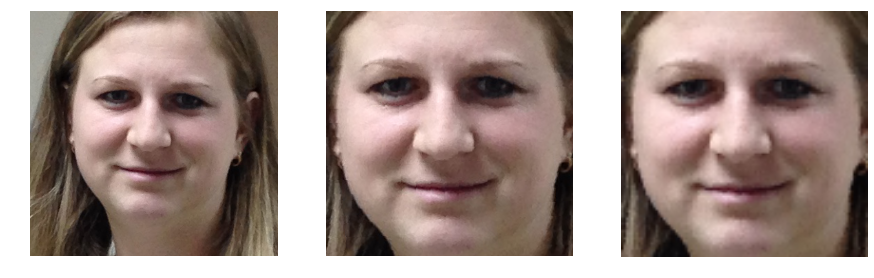

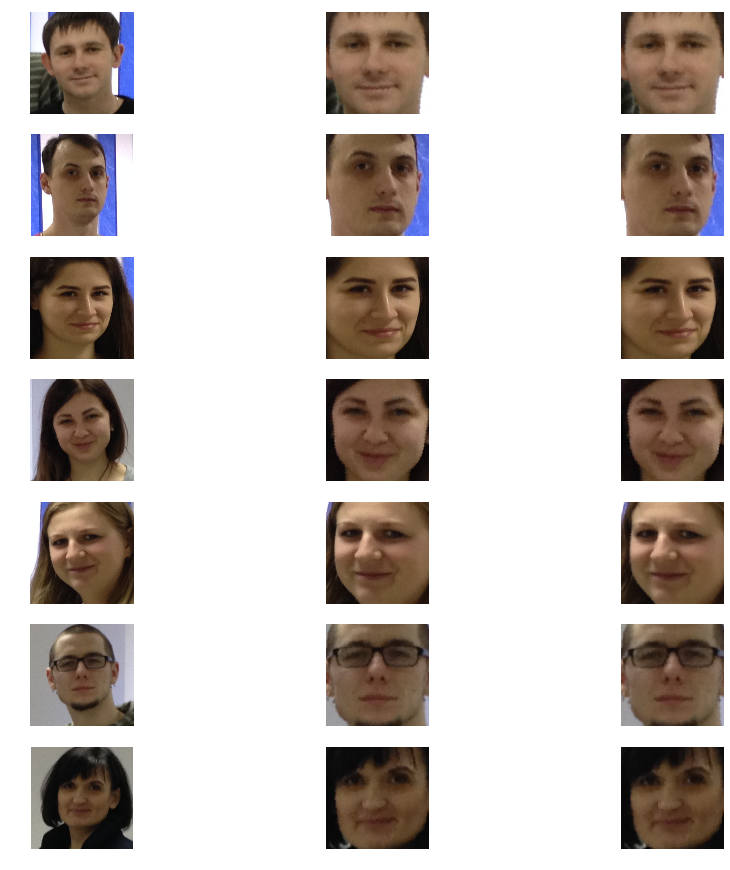

In [91]:
'''Transform faces to matrices.'''

for item in result:
    result[item]['faces_matrix'] = np.zeros(shape=(result[item]['total_faces'], FACE_RESOLUTION ** 2))
    
    fig = plt.figure(figsize=(15,15))

    for i in range(result[item]['total_faces']):
        vertices = result[item]['faces'][i]['fdBoundingPoly']['vertices']
        
        box = (vertices[0]['x'], vertices[1]['y'], vertices[1]['x'], vertices[2]['y'],)
        rotated_box = (vertices[0]['x']-50, vertices[1]['y']-50, vertices[1]['x']+50, vertices[2]['y']+50,)
#         print('box: {}'.format(box))
#         print('rotated box: {}'.format(rotated_box))        
        original_face = result[item]['original_image'].crop(rotated_box)
        
        pos = i*3+1
        plt.subplot(result[item]['total_faces'], 3, pos)
        plt.imshow(original_face)    
        plt.axis("off")
        
        rotated_face = original_face.rotate(result[item]['faces'][i]['rollAngle'])
        
        cropped_face = rotated_face.crop((50, 50, box[2]-box[0]+50, box[3]-box[1]+50,))

        pos = i*3+2
        plt.subplot(result[item]['total_faces'], 3, pos)
        plt.imshow(cropped_face)    
        plt.axis("off")
        
        scaled_face = cropped_face.resize(([FACE_RESOLUTION, FACE_RESOLUTION]))
        
        pos = i*3+3
        plt.subplot(result[item]['total_faces'], 3, pos)
        plt.imshow(scaled_face)    
        plt.axis("off")
        
        converted_face = scaled_face.convert('L')
        result[item]['faces_matrix'][i] = np.asmatrix(converted_face).A1

Calc disimilarity matrix
==

In [92]:
predicted = np.argmin(np.linalg.norm(result['group']['faces_matrix']-result['single']['faces_matrix'], axis=1))
# print(predicted)

4


Show result
==

(-0.5, 3263.5, 2447.5, -0.5)

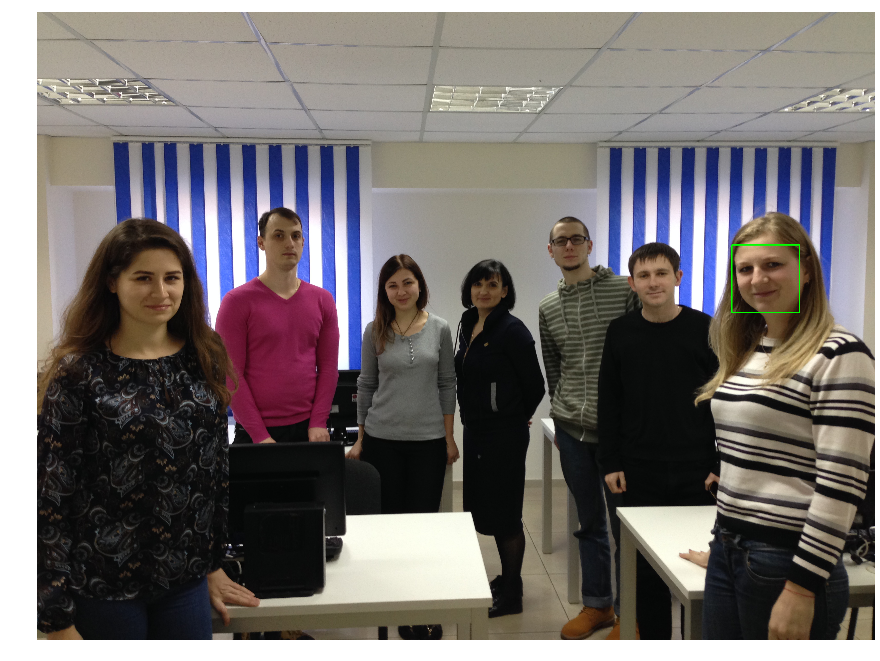

In [93]:
draw = ImageDraw.Draw(result['group']['original_image'])
box = [(v.get('x', 0.0), v.get('y', 0.0)) for v in result['group']['faces'][predicted]['fdBoundingPoly']['vertices']]
draw.line(box + [box[0]], width=5, fill='#00ff00')
del draw
    
# plot group image
fig = plt.figure(figsize=(15,15))
plt.subplot(111)
plt.imshow(result['group']['original_image'])    
plt.axis("off")

Simple algorithm
g1, g7

Align

g1, g3, g4, g5, g6, g7